In [1]:
from keras.models import Model
from keras import layers
from keras.layers import Input, Dense,Conv2D, Activation, BatchNormalization
from keras.layers import MaxPooling2D, AveragePooling2D, Dropout, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.data_utils import get_file

C:\Users\JHLee\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def convLayer(x,filters,num_row,num_col,padding='same',strides=(1, 1),
              normalizer=True,activation='relu'):
    
    if K.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3

    x = Conv2D(filters, (num_row, num_col),strides=strides, 
               padding=padding,use_bias=False)(x)

    if normalizer:
        x = BatchNormalization(axis=bn_axis, scale=False)(x)
    
    if activation:
        x = Activation(activation)(x)
    
    return x

## 19 layer vggnet 


In [3]:
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5'

def vggnet(weights = None, input_shape=None,classes=1000):
    input_shape = _obtain_input_shape(input_shape,default_size=32,min_size=15,
        data_format=K.image_data_format(),require_flatten=True)

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    # 'Sequential bit at start'
    img_input = Input(shape=input_shape)
    x = img_input
    x = convLayer(x,  64, 3, 3, padding='same') 
    x = convLayer(x,  64, 3, 3, padding='same')
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  
    
    x = convLayer(x, 128, 3, 3, padding='same')  
    x = convLayer(x, 128, 3, 3, padding='same')  
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  
    
    x = convLayer(x,256, 3, 3, padding='same')  
    x = convLayer(x,256, 3, 3, padding='same')  
    x = convLayer(x,256, 3, 3, padding='same')  
    x = convLayer(x,256, 3, 3, padding='same')  
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  

    x = convLayer(x, 512, 3, 3, padding='same')  
    x = convLayer(x, 512, 3, 3, padding='same') 
    x = convLayer(x, 512, 3, 3, padding='same')  
    x = convLayer(x, 512, 3, 3, padding='same') 
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  
   
    x = convLayer(x, 512, 3, 3, padding='same')  
    x = convLayer(x, 512, 3, 3, padding='same') 
    x = convLayer(x, 512, 3, 3, padding='same')  
    x = convLayer(x, 512, 3, 3, padding='same')  
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(4096, activation = 'relu')(x)
    x = Dense(4096, activation = 'relu')(x)
    x = Dense(classes)(x)
    loss= Activation('softmax')(x)
    
    inputs = img_input
    vggnet = Model(inputs,loss)
    
    if weights == 'imagenet':
        weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        vggnet.load_weights(weights_path)    
        
    return vggnet

In [4]:
def preprocess_input(x):
    x /= 255.0
    x -= 0.5
    x *= 2.
    return x

In [5]:
from keras.datasets import cifar10
np.random.seed(1000)
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()


In [6]:
if __name__ =='__main__' :
    model = vggnet(classes = 10)
    # X_train, X_test , Y_train, Y_test를 불러왔다고 가정한다면
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), loss='categorical_crossentropy',metrics=['accuracy'])
    hist = model.fit(X_train/255.0, to_categorical(Y_train),
              batch_size=128,
              shuffle=True,
              epochs=150,
              validation_data=((X_test)/255.0, to_categorical(Y_test)),
              callbacks=[EarlyStopping(min_delta=0.001, patience=20)])

    scores = model.evaluate((X_test)/255.0, to_categorical(Y_test))
    print('Loss: %.3f' % scores[0])
    print('test Accuracy: %.3f' % scores[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/150
50000/50000 [==============================] - 49s 979us/step - loss: 1.3690 - acc: 0.5013 - val_loss: 1.4032 - val_acc: 0.5401
Epoch 2/150
50000/50000 [==============================] - 43s 853us/step - loss: 0.9305 - acc: 0.6696 - val_loss: 1.0286 - val_acc: 0.6602
Epoch 3/150
50000/50000 [==============================] - 43s 864us/step - loss: 0.7067 - acc: 0.7535 - val_loss: 1.2456 - val_acc: 0.5966
Epoch 4/150
50000/50000 [==============================] - 42s 846us/step - loss: 0.5296 - acc: 0.8179 - val_loss: 1.0531 - val_acc: 0.6780
Epoch 5/150
50000/50000 [==============================] - 42s 847us/step - loss: 0.3968 - acc: 0.8633 - val_loss: 0.9315 - val_acc: 0.7166
Epoch 6/150
50000/50000 [==============================] - 42s 846us/step - loss: 0.2832 - acc: 0.9035 - val_loss: 1.1067 - val_acc: 0.6870
Epoch 7/150
50000/50000 [==============================] - 42s 847us/step - loss: 0.2179 - acc: 0.9266 - val_l

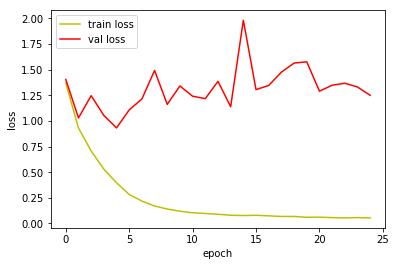

In [7]:
fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.show()   

## 결과 해석

vggnet은 vanishing gradient을 해결하기 위해서 단순한 구조의 11 layer 을 학습시켜 나온 값을 초기의 4개와 마지막 fc 에 초기값으로 사용한다고 했다. 
단순하게 adam으로 학습시켜서 val loss의 값이 저렇게 변한게 아닌가 싶다! 
* 이런 weight를 어떻게 사용하는지 나중에 공부해보기